# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.733688  0.380281  0.0  0.172034  1.018888  1.641836  1  3  15.139325   
1 -0.165987  2.861682  0.0  0.579434  0.070982 -0.519538  2  1  12.000764   
2  0.676372 -0.653404  0.0  0.859570  0.927707 -0.088589  0  0  10.800234   
3 -0.695101  0.875387  1.0  0.739883  0.923987  1.755349  3  2  32.681015   
4  0.125746  1.787860  0.0  0.098727 -0.332722 -0.570551  3  0   3.539056   

            y  
0  174.042347  
1  145.913272  
2  108.924845  
3  357.154145  
4   37.760073  
True causal estimate is 10.220133394893494


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

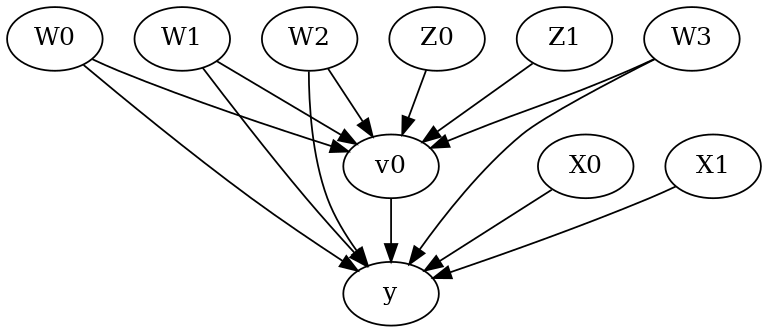

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

## Realized estimand
b: y~v0+W1+W2+W3+W0+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 10.22026663939738



## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

## Realized estimand
b: y~v0+W1+W2+W3+W0 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 10.557088177977514
Effect estimates: [[11.22899827]
 [10.28374009]
 [10.04218672]
 [ 9.86732148]
 [ 9.90036384]
 [11.12562771]
 [ 9.75292597]
 [11.20997562]
 [10.25921142]
 [10.88428538]
 [11.63431639]
 [ 9.9064196 ]
 [ 9.85512541]
 [ 9.3523501 ]
 [10.98414668]
 [10.15323828]
 [11.28469642]
 [11.40223341]
 [10.78020315]
 [10.67445275]
 [11.09783547]
 [11.04963086]
 [11.12695763]
 [10.45510281]
 [10.06805117]
 [10.83292242]
 [ 9.98449693]
 [10.41815832]
 [ 9.98929457]
 [10.07594857]
 [11.35774509]
 [10.18139544]
 [10.64564663]
 [ 9.717

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.220133394893494


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

## Realized estimand
b: y~v0+W1+W2+W3+W0 | X0,X1
Target units: 

## Estimate
Mean value: 10.187976949913804
Effect estimates: [[10.05680912]
 [11.78249457]
 [ 9.66814838]
 ...
 [10.8036995 ]
 [ 9.75116265]
 [ 9.66604971]]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

## Realized estimand
b: y~v0+W1+W2+W3+W0 | X0,X1
Target units: ate

## Estimate
Mean value: 10.188618798593344
Effect estimates: [[10.05898837]
 [11.69842009]
 [ 9.71193812]
 ...
 [10.80373559]
 [ 9.77914405]
 [ 9.69136358]]
95.0% confidence interval: [[[10.05234962 11.62807103  9.69295263 ... 10.77792207  9.77310774
    9.68052537]]

 [[10.10653765 11.80436643  9.80459577 ... 10.933517    9.84691538
    9.75455627]]]



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[[10.21866732]
 [10.25195511]
 [10.27948939]
 [10.12230608]
 [10.27056848]
 [10.77980341]
 [10.17381863]
 [10.2733151 ]
 [10.28217551]
 [10.29742438]]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.093979  2.031034  0.0  0.641204  0.271104 -0.497026  0.278736   
1     1.015160  1.543616  0.0  0.213852 -0.910212  0.771139  0.671322   
2     0.522549 -0.023513  1.0  0.404252  0.892057  0.757896  0.008882   
3    -0.326395  1.054751  1.0  0.788419  1.174741  0.290893  0.836551   
4     0.895668 -0.634359  0.0  0.354609  0.321203 -0.293558  1.709419   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.023058  2.217366  0.0  0.713032 -0.085500  0.941000  0.280015   
9996 -1.300207  1.603825  0.0  0.496313  2.155906  0.492697 -0.092526   
9997  1.687289  1.276737  0.0  0.007855  0.429587  1.168977  0.322497   
9998 -0.003560 -0.904824  1.0  0.529196  0.832262  0.625693  0.599591   
9999 -2.028533  0.407383  0.0  0.189059 -1.416905  1.513295  1.585543   

            W3  v0  y  
0     0.534203   1  1  
1    -0.401496   1  1  
2    -1.547256   1  1  
3    -0.820792   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W3,W0])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W0,U) = P(y|v0,W1,W2,W3,W0)

## Realized estimand
b: y~v0+W1+W2+W3+W0 | X0,X1
Target units: ate

## Estimate
Mean value: 0.6299135740760873
Effect estimates: [[0.67780917]
 [0.6569347 ]
 [0.59859515]
 ...
 [0.645365  ]
 [0.5663251 ]
 [0.6204447 ]]

True causal estimate is 0.2829


### Instrumental Variable Method

In [16]:
import keras
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.iv.nnet.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2023-02-10 14:32:02.588901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 14:32:02.735377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 14:32:02.735446: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-10 14:32:03.472443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-10 14:32:03.472565: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-10 14:32:03.472575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2023-02-10 14:32:04.256891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-10 14:32:04.256923: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-10 14:32:04.256948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (da1e931ff4ea): /proc/driver/nvidia/version does not exist
2023-02-10 14:32:04.257423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 5:32 - loss: 102.2989

 34/313 [==>...........................] - ETA: 0s - loss: 28.7736   

 68/313 [=====>........................] - ETA: 0s - loss: 16.7722

103/313 [========>.....................] - ETA: 0s - loss: 12.4842

138/313 [============>.................] - ETA: 0s - loss: 10.3041

171/313 [===============>..............] - ETA: 0s - loss: 9.0354 

204/313 [==================>...........] - ETA: 0s - loss: 8.1647

238/313 [=====================>........] - ETA: 0s - loss: 7.4943

272/313 [=========================>....] - ETA: 0s - loss: 6.9859

307/313 [============================>.] - ETA: 0s - loss: 6.5586

313/313 [==============================] - 2s 2ms/step - loss: 6.4921


Epoch 2/25


  1/313 [..............................] - ETA: 0s - loss: 3.2142

 36/313 [==>...........................] - ETA: 0s - loss: 2.9834

 71/313 [=====>........................] - ETA: 0s - loss: 2.8678

105/313 [=========>....................] - ETA: 0s - loss: 2.8101

140/313 [============>.................] - ETA: 0s - loss: 2.7638

175/313 [===============>..............] - ETA: 0s - loss: 2.7050

209/313 [===================>..........] - ETA: 0s - loss: 2.6598

243/313 [======================>.......] - ETA: 0s - loss: 2.6210

277/313 [=========================>....] - ETA: 0s - loss: 2.5888

312/313 [============================>.] - ETA: 0s - loss: 2.5576

313/313 [==============================] - 0s 1ms/step - loss: 2.5569


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 2.4080

 37/313 [==>...........................] - ETA: 0s - loss: 2.3038

 73/313 [=====>........................] - ETA: 0s - loss: 2.2819

108/313 [=========>....................] - ETA: 0s - loss: 2.2654

142/313 [============>.................] - ETA: 0s - loss: 2.2454

176/313 [===============>..............] - ETA: 0s - loss: 2.2298

209/313 [===================>..........] - ETA: 0s - loss: 2.2214

242/313 [======================>.......] - ETA: 0s - loss: 2.2173

277/313 [=========================>....] - ETA: 0s - loss: 2.2034

312/313 [============================>.] - ETA: 0s - loss: 2.1961

313/313 [==============================] - 0s 1ms/step - loss: 2.1959


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.2701

 36/313 [==>...........................] - ETA: 0s - loss: 2.1534

 70/313 [=====>........................] - ETA: 0s - loss: 2.1253

105/313 [=========>....................] - ETA: 0s - loss: 2.1195

139/313 [============>.................] - ETA: 0s - loss: 2.1167

174/313 [===============>..............] - ETA: 0s - loss: 2.1168

209/313 [===================>..........] - ETA: 0s - loss: 2.1130

243/313 [======================>.......] - ETA: 0s - loss: 2.1091

279/313 [=========================>....] - ETA: 0s - loss: 2.1004

313/313 [==============================] - 0s 1ms/step - loss: 2.1006


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 1.9706

 36/313 [==>...........................] - ETA: 0s - loss: 2.0857

 70/313 [=====>........................] - ETA: 0s - loss: 2.0904

105/313 [=========>....................] - ETA: 0s - loss: 2.0894

139/313 [============>.................] - ETA: 0s - loss: 2.0849

174/313 [===============>..............] - ETA: 0s - loss: 2.0765

209/313 [===================>..........] - ETA: 0s - loss: 2.0697

244/313 [======================>.......] - ETA: 0s - loss: 2.0651

278/313 [=========================>....] - ETA: 0s - loss: 2.0664

313/313 [==============================] - ETA: 0s - loss: 2.0631

313/313 [==============================] - 0s 1ms/step - loss: 2.0631


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 2.1329

 36/313 [==>...........................] - ETA: 0s - loss: 2.0438

 71/313 [=====>........................] - ETA: 0s - loss: 2.0377

105/313 [=========>....................] - ETA: 0s - loss: 2.0514

140/313 [============>.................] - ETA: 0s - loss: 2.0497

175/313 [===============>..............] - ETA: 0s - loss: 2.0400

209/313 [===================>..........] - ETA: 0s - loss: 2.0379

245/313 [======================>.......] - ETA: 0s - loss: 2.0353

280/313 [=========================>....] - ETA: 0s - loss: 2.0318

313/313 [==============================] - 0s 1ms/step - loss: 2.0345


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 1.9225

 36/313 [==>...........................] - ETA: 0s - loss: 2.0271

 70/313 [=====>........................] - ETA: 0s - loss: 2.0129

105/313 [=========>....................] - ETA: 0s - loss: 2.0124

140/313 [============>.................] - ETA: 0s - loss: 2.0086

175/313 [===============>..............] - ETA: 0s - loss: 2.0128

210/313 [===================>..........] - ETA: 0s - loss: 2.0117

246/313 [======================>.......] - ETA: 0s - loss: 2.0090

282/313 [==========================>...] - ETA: 0s - loss: 2.0091

313/313 [==============================] - 0s 1ms/step - loss: 2.0103


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.3999

 37/313 [==>...........................] - ETA: 0s - loss: 2.0301

 73/313 [=====>........................] - ETA: 0s - loss: 2.0227

109/313 [=========>....................] - ETA: 0s - loss: 2.0128

143/313 [============>.................] - ETA: 0s - loss: 2.0020

179/313 [================>.............] - ETA: 0s - loss: 1.9983

215/313 [===================>..........] - ETA: 0s - loss: 1.9973

251/313 [=======================>......] - ETA: 0s - loss: 1.9921

285/313 [==========================>...] - ETA: 0s - loss: 1.9944

313/313 [==============================] - 0s 1ms/step - loss: 1.9968


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2.0733

 36/313 [==>...........................] - ETA: 0s - loss: 1.9794

 71/313 [=====>........................] - ETA: 0s - loss: 2.0118

105/313 [=========>....................] - ETA: 0s - loss: 1.9998

136/313 [============>.................] - ETA: 0s - loss: 2.0013

170/313 [===============>..............] - ETA: 0s - loss: 2.0023

205/313 [==================>...........] - ETA: 0s - loss: 1.9916

240/313 [======================>.......] - ETA: 0s - loss: 1.9908

275/313 [=========================>....] - ETA: 0s - loss: 1.9874

307/313 [============================>.] - ETA: 0s - loss: 1.9873

313/313 [==============================] - 0s 2ms/step - loss: 1.9864


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 1.8659

 36/313 [==>...........................] - ETA: 0s - loss: 1.9244

 69/313 [=====>........................] - ETA: 0s - loss: 1.9471

103/313 [========>.....................] - ETA: 0s - loss: 1.9653

136/313 [============>.................] - ETA: 0s - loss: 1.9612

169/313 [===============>..............] - ETA: 0s - loss: 1.9624

203/313 [==================>...........] - ETA: 0s - loss: 1.9671

237/313 [=====================>........] - ETA: 0s - loss: 1.9711

271/313 [========================>.....] - ETA: 0s - loss: 1.9702

304/313 [============================>.] - ETA: 0s - loss: 1.9726

313/313 [==============================] - 0s 2ms/step - loss: 1.9712


Epoch 11/25


  1/313 [..............................] - ETA: 0s - loss: 1.7048

 36/313 [==>...........................] - ETA: 0s - loss: 1.9739

 71/313 [=====>........................] - ETA: 0s - loss: 1.9889

106/313 [=========>....................] - ETA: 0s - loss: 1.9833

141/313 [============>.................] - ETA: 0s - loss: 1.9669

174/313 [===============>..............] - ETA: 0s - loss: 1.9716

208/313 [==================>...........] - ETA: 0s - loss: 1.9718

243/313 [======================>.......] - ETA: 0s - loss: 1.9719

277/313 [=========================>....] - ETA: 0s - loss: 1.9680

310/313 [============================>.] - ETA: 0s - loss: 1.9668

313/313 [==============================] - 0s 1ms/step - loss: 1.9666


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2.0178

 35/313 [==>...........................] - ETA: 0s - loss: 1.9222

 70/313 [=====>........................] - ETA: 0s - loss: 1.9397

104/313 [========>.....................] - ETA: 0s - loss: 1.9409

138/313 [============>.................] - ETA: 0s - loss: 1.9456

171/313 [===============>..............] - ETA: 0s - loss: 1.9529

206/313 [==================>...........] - ETA: 0s - loss: 1.9506

239/313 [=====================>........] - ETA: 0s - loss: 1.9505

273/313 [=========================>....] - ETA: 0s - loss: 1.9550

307/313 [============================>.] - ETA: 0s - loss: 1.9557

313/313 [==============================] - 0s 1ms/step - loss: 1.9555


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 1.9675

 35/313 [==>...........................] - ETA: 0s - loss: 1.9558

 68/313 [=====>........................] - ETA: 0s - loss: 1.9572

102/313 [========>.....................] - ETA: 0s - loss: 1.9505

136/313 [============>.................] - ETA: 0s - loss: 1.9461

171/313 [===============>..............] - ETA: 0s - loss: 1.9473

205/313 [==================>...........] - ETA: 0s - loss: 1.9518

239/313 [=====================>........] - ETA: 0s - loss: 1.9506

273/313 [=========================>....] - ETA: 0s - loss: 1.9500

307/313 [============================>.] - ETA: 0s - loss: 1.9490

313/313 [==============================] - 0s 1ms/step - loss: 1.9477


Epoch 14/25


  1/313 [..............................] - ETA: 0s - loss: 2.0128

 35/313 [==>...........................] - ETA: 0s - loss: 1.9414

 69/313 [=====>........................] - ETA: 0s - loss: 1.9326

103/313 [========>.....................] - ETA: 0s - loss: 1.9339

138/313 [============>.................] - ETA: 0s - loss: 1.9349

170/313 [===============>..............] - ETA: 0s - loss: 1.9376

203/313 [==================>...........] - ETA: 0s - loss: 1.9319

237/313 [=====================>........] - ETA: 0s - loss: 1.9333

269/313 [========================>.....] - ETA: 0s - loss: 1.9368

303/313 [============================>.] - ETA: 0s - loss: 1.9362

313/313 [==============================] - 0s 2ms/step - loss: 1.9355


Epoch 15/25


  1/313 [..............................] - ETA: 0s - loss: 2.1769

 35/313 [==>...........................] - ETA: 0s - loss: 1.9424

 69/313 [=====>........................] - ETA: 0s - loss: 1.9653

101/313 [========>.....................] - ETA: 0s - loss: 1.9563

135/313 [===========>..................] - ETA: 0s - loss: 1.9547

169/313 [===============>..............] - ETA: 0s - loss: 1.9424

202/313 [==================>...........] - ETA: 0s - loss: 1.9379

235/313 [=====================>........] - ETA: 0s - loss: 1.9380

269/313 [========================>.....] - ETA: 0s - loss: 1.9372

302/313 [===========================>..] - ETA: 0s - loss: 1.9355

313/313 [==============================] - 0s 2ms/step - loss: 1.9353


Epoch 16/25


  1/313 [..............................] - ETA: 0s - loss: 2.1706

 33/313 [==>...........................] - ETA: 0s - loss: 1.9469

 67/313 [=====>........................] - ETA: 0s - loss: 1.9486

100/313 [========>.....................] - ETA: 0s - loss: 1.9421

133/313 [===========>..................] - ETA: 0s - loss: 1.9371

166/313 [==============>...............] - ETA: 0s - loss: 1.9364

200/313 [==================>...........] - ETA: 0s - loss: 1.9302

234/313 [=====================>........] - ETA: 0s - loss: 1.9291

268/313 [========================>.....] - ETA: 0s - loss: 1.9303

302/313 [===========================>..] - ETA: 0s - loss: 1.9329

313/313 [==============================] - 0s 2ms/step - loss: 1.9324


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 1.9448

 35/313 [==>...........................] - ETA: 0s - loss: 1.9552

 69/313 [=====>........................] - ETA: 0s - loss: 1.9422

103/313 [========>.....................] - ETA: 0s - loss: 1.9460

138/313 [============>.................] - ETA: 0s - loss: 1.9417

171/313 [===============>..............] - ETA: 0s - loss: 1.9381

205/313 [==================>...........] - ETA: 0s - loss: 1.9359

240/313 [======================>.......] - ETA: 0s - loss: 1.9398

273/313 [=========================>....] - ETA: 0s - loss: 1.9409

306/313 [============================>.] - ETA: 0s - loss: 1.9389

313/313 [==============================] - 0s 1ms/step - loss: 1.9383


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 1.9461

 35/313 [==>...........................] - ETA: 0s - loss: 1.8991

 69/313 [=====>........................] - ETA: 0s - loss: 1.9091

103/313 [========>.....................] - ETA: 0s - loss: 1.9045

138/313 [============>.................] - ETA: 0s - loss: 1.9079

172/313 [===============>..............] - ETA: 0s - loss: 1.9165

207/313 [==================>...........] - ETA: 0s - loss: 1.9189

240/313 [======================>.......] - ETA: 0s - loss: 1.9202

275/313 [=========================>....] - ETA: 0s - loss: 1.9174

308/313 [============================>.] - ETA: 0s - loss: 1.9169

313/313 [==============================] - 0s 1ms/step - loss: 1.9167


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 1.7644

 37/313 [==>...........................] - ETA: 0s - loss: 1.9050

 70/313 [=====>........................] - ETA: 0s - loss: 1.9075

103/313 [========>.....................] - ETA: 0s - loss: 1.9097

137/313 [============>.................] - ETA: 0s - loss: 1.9072

170/313 [===============>..............] - ETA: 0s - loss: 1.9040

204/313 [==================>...........] - ETA: 0s - loss: 1.9053

239/313 [=====================>........] - ETA: 0s - loss: 1.9063

272/313 [=========================>....] - ETA: 0s - loss: 1.9086

306/313 [============================>.] - ETA: 0s - loss: 1.9108

313/313 [==============================] - 0s 2ms/step - loss: 1.9094


Epoch 20/25


  1/313 [..............................] - ETA: 0s - loss: 1.9679

 36/313 [==>...........................] - ETA: 0s - loss: 1.9073

 71/313 [=====>........................] - ETA: 0s - loss: 1.9230

105/313 [=========>....................] - ETA: 0s - loss: 1.9276

140/313 [============>.................] - ETA: 0s - loss: 1.9175

173/313 [===============>..............] - ETA: 0s - loss: 1.9180

207/313 [==================>...........] - ETA: 0s - loss: 1.9159

242/313 [======================>.......] - ETA: 0s - loss: 1.9143

275/313 [=========================>....] - ETA: 0s - loss: 1.9160

310/313 [============================>.] - ETA: 0s - loss: 1.9159

313/313 [==============================] - 0s 1ms/step - loss: 1.9161


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 1.7488

 35/313 [==>...........................] - ETA: 0s - loss: 1.9212

 70/313 [=====>........................] - ETA: 0s - loss: 1.9232

104/313 [========>.....................] - ETA: 0s - loss: 1.9248

139/313 [============>.................] - ETA: 0s - loss: 1.9156

173/313 [===============>..............] - ETA: 0s - loss: 1.9142

205/313 [==================>...........] - ETA: 0s - loss: 1.9141

239/313 [=====================>........] - ETA: 0s - loss: 1.9109

273/313 [=========================>....] - ETA: 0s - loss: 1.9099

309/313 [============================>.] - ETA: 0s - loss: 1.9045

313/313 [==============================] - 0s 1ms/step - loss: 1.9040


Epoch 22/25


  1/313 [..............................] - ETA: 0s - loss: 2.0408

 35/313 [==>...........................] - ETA: 0s - loss: 1.8721

 70/313 [=====>........................] - ETA: 0s - loss: 1.8889

105/313 [=========>....................] - ETA: 0s - loss: 1.8937

139/313 [============>.................] - ETA: 0s - loss: 1.8952

173/313 [===============>..............] - ETA: 0s - loss: 1.8967

205/313 [==================>...........] - ETA: 0s - loss: 1.8951

239/313 [=====================>........] - ETA: 0s - loss: 1.8918

273/313 [=========================>....] - ETA: 0s - loss: 1.8952

308/313 [============================>.] - ETA: 0s - loss: 1.8984

313/313 [==============================] - 0s 1ms/step - loss: 1.9005


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 1.8803

 35/313 [==>...........................] - ETA: 0s - loss: 1.9053

 69/313 [=====>........................] - ETA: 0s - loss: 1.8990

103/313 [========>.....................] - ETA: 0s - loss: 1.9024

137/313 [============>.................] - ETA: 0s - loss: 1.9009

172/313 [===============>..............] - ETA: 0s - loss: 1.9056

205/313 [==================>...........] - ETA: 0s - loss: 1.9061

238/313 [=====================>........] - ETA: 0s - loss: 1.9021

272/313 [=========================>....] - ETA: 0s - loss: 1.9010

306/313 [============================>.] - ETA: 0s - loss: 1.8991

313/313 [==============================] - 0s 1ms/step - loss: 1.8988


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 1.8169

 36/313 [==>...........................] - ETA: 0s - loss: 1.9027

 70/313 [=====>........................] - ETA: 0s - loss: 1.9051

105/313 [=========>....................] - ETA: 0s - loss: 1.9025

140/313 [============>.................] - ETA: 0s - loss: 1.8984

174/313 [===============>..............] - ETA: 0s - loss: 1.8913

208/313 [==================>...........] - ETA: 0s - loss: 1.8919

242/313 [======================>.......] - ETA: 0s - loss: 1.8967

278/313 [=========================>....] - ETA: 0s - loss: 1.8971

311/313 [============================>.] - ETA: 0s - loss: 1.8973

313/313 [==============================] - 0s 1ms/step - loss: 1.8981


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 1.9667

 33/313 [==>...........................] - ETA: 0s - loss: 1.8863

 68/313 [=====>........................] - ETA: 0s - loss: 1.8849

102/313 [========>.....................] - ETA: 0s - loss: 1.8925

136/313 [============>.................] - ETA: 0s - loss: 1.8869

170/313 [===============>..............] - ETA: 0s - loss: 1.8825

205/313 [==================>...........] - ETA: 0s - loss: 1.8869

239/313 [=====================>........] - ETA: 0s - loss: 1.8886

272/313 [=========================>....] - ETA: 0s - loss: 1.8898

306/313 [============================>.] - ETA: 0s - loss: 1.8924

313/313 [==============================] - 0s 2ms/step - loss: 1.8921


Epoch 1/25


  1/313 [..............................] - ETA: 7:37 - loss: 33086.5273

 30/313 [=>............................] - ETA: 0s - loss: 25828.4590  

 59/313 [====>.........................] - ETA: 0s - loss: 19228.7285

 85/313 [=======>......................] - ETA: 0s - loss: 14846.5166

114/313 [=========>....................] - ETA: 0s - loss: 12247.7734

141/313 [============>.................] - ETA: 0s - loss: 10823.4180

169/313 [===============>..............] - ETA: 0s - loss: 9766.2607 

197/313 [=================>............] - ETA: 0s - loss: 9005.5078

226/313 [====================>.........] - ETA: 0s - loss: 8355.5771

255/313 [=======================>......] - ETA: 0s - loss: 7890.7168

284/313 [==========================>...] - ETA: 0s - loss: 7539.3423

311/313 [============================>.] - ETA: 0s - loss: 7226.6943

313/313 [==============================] - 2s 2ms/step - loss: 7226.3428


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 6209.7305

 25/313 [=>............................] - ETA: 0s - loss: 4508.8184

 54/313 [====>.........................] - ETA: 0s - loss: 4248.3076

 82/313 [======>.......................] - ETA: 0s - loss: 4216.1841

111/313 [=========>....................] - ETA: 0s - loss: 4142.2056

140/313 [============>.................] - ETA: 0s - loss: 4166.0132

169/313 [===============>..............] - ETA: 0s - loss: 4151.1821

197/313 [=================>............] - ETA: 0s - loss: 4075.6536

225/313 [====================>.........] - ETA: 0s - loss: 4052.5745

251/313 [=======================>......] - ETA: 0s - loss: 4006.8877

277/313 [=========================>....] - ETA: 0s - loss: 3981.8958

303/313 [============================>.] - ETA: 0s - loss: 3945.2124

313/313 [==============================] - 1s 2ms/step - loss: 3924.2495


Epoch 3/25


  1/313 [..............................] - ETA: 0s - loss: 1942.6414

 30/313 [=>............................] - ETA: 0s - loss: 3625.5071

 59/313 [====>.........................] - ETA: 0s - loss: 3589.7285

 87/313 [=======>......................] - ETA: 0s - loss: 3607.3416

115/313 [==========>...................] - ETA: 0s - loss: 3612.3694

141/313 [============>.................] - ETA: 0s - loss: 3659.4766

168/313 [===============>..............] - ETA: 0s - loss: 3712.6001

197/313 [=================>............] - ETA: 0s - loss: 3734.8157

226/313 [====================>.........] - ETA: 0s - loss: 3709.4016

254/313 [=======================>......] - ETA: 0s - loss: 3729.9575

282/313 [==========================>...] - ETA: 0s - loss: 3722.5918

311/313 [============================>.] - ETA: 0s - loss: 3708.9309

313/313 [==============================] - 1s 2ms/step - loss: 3699.4780


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 3487.0513

 30/313 [=>............................] - ETA: 0s - loss: 3851.3477

 58/313 [====>.........................] - ETA: 0s - loss: 3852.6135

 86/313 [=======>......................] - ETA: 0s - loss: 3816.9888

114/313 [=========>....................] - ETA: 0s - loss: 3766.2283

141/313 [============>.................] - ETA: 0s - loss: 3783.9148

170/313 [===============>..............] - ETA: 0s - loss: 3750.3762

198/313 [=================>............] - ETA: 0s - loss: 3766.2102

226/313 [====================>.........] - ETA: 0s - loss: 3754.8079

254/313 [=======================>......] - ETA: 0s - loss: 3719.2524

282/313 [==========================>...] - ETA: 0s - loss: 3731.5310

311/313 [============================>.] - ETA: 0s - loss: 3724.4316

313/313 [==============================] - 1s 2ms/step - loss: 3725.9666


Epoch 5/25


  1/313 [..............................] - ETA: 0s - loss: 5923.7900

 30/313 [=>............................] - ETA: 0s - loss: 3768.3435

 58/313 [====>.........................] - ETA: 0s - loss: 3749.0583

 86/313 [=======>......................] - ETA: 0s - loss: 3744.6021

114/313 [=========>....................] - ETA: 0s - loss: 3710.4055

142/313 [============>.................] - ETA: 0s - loss: 3772.2703

170/313 [===============>..............] - ETA: 0s - loss: 3718.0020

199/313 [==================>...........] - ETA: 0s - loss: 3682.2114

227/313 [====================>.........] - ETA: 0s - loss: 3631.6802

256/313 [=======================>......] - ETA: 0s - loss: 3607.0381

284/313 [==========================>...] - ETA: 0s - loss: 3641.5552

312/313 [============================>.] - ETA: 0s - loss: 3615.8445

313/313 [==============================] - 1s 2ms/step - loss: 3614.1628


Epoch 6/25


  1/313 [..............................] - ETA: 0s - loss: 3013.1187

 29/313 [=>............................] - ETA: 0s - loss: 3638.5674

 58/313 [====>.........................] - ETA: 0s - loss: 3713.4082

 87/313 [=======>......................] - ETA: 0s - loss: 3778.4978

115/313 [==========>...................] - ETA: 0s - loss: 3712.9578

143/313 [============>.................] - ETA: 0s - loss: 3706.6255

171/313 [===============>..............] - ETA: 0s - loss: 3719.9102

199/313 [==================>...........] - ETA: 0s - loss: 3705.7568

227/313 [====================>.........] - ETA: 0s - loss: 3711.1936

255/313 [=======================>......] - ETA: 0s - loss: 3712.0100

283/313 [==========================>...] - ETA: 0s - loss: 3705.4016

311/313 [============================>.] - ETA: 0s - loss: 3715.2854

313/313 [==============================] - 1s 2ms/step - loss: 3711.4873


Epoch 7/25


  1/313 [..............................] - ETA: 0s - loss: 3945.7866

 30/313 [=>............................] - ETA: 0s - loss: 3723.8325

 58/313 [====>.........................] - ETA: 0s - loss: 3695.4065

 86/313 [=======>......................] - ETA: 0s - loss: 3714.5215

114/313 [=========>....................] - ETA: 0s - loss: 3796.1614

142/313 [============>.................] - ETA: 0s - loss: 3729.7126

170/313 [===============>..............] - ETA: 0s - loss: 3752.2986

198/313 [=================>............] - ETA: 0s - loss: 3738.8179

227/313 [====================>.........] - ETA: 0s - loss: 3733.9329

255/313 [=======================>......] - ETA: 0s - loss: 3727.2930

284/313 [==========================>...] - ETA: 0s - loss: 3708.8894

308/313 [============================>.] - ETA: 0s - loss: 3735.6870

313/313 [==============================] - 1s 2ms/step - loss: 3731.1162


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2681.0508

 29/313 [=>............................] - ETA: 0s - loss: 3797.4590

 57/313 [====>.........................] - ETA: 0s - loss: 3772.2791

 86/313 [=======>......................] - ETA: 0s - loss: 3694.7761

114/313 [=========>....................] - ETA: 0s - loss: 3665.6025

142/313 [============>.................] - ETA: 0s - loss: 3631.8650

170/313 [===============>..............] - ETA: 0s - loss: 3639.0166

198/313 [=================>............] - ETA: 0s - loss: 3645.7097

226/313 [====================>.........] - ETA: 0s - loss: 3611.5962

255/313 [=======================>......] - ETA: 0s - loss: 3654.4255

284/313 [==========================>...] - ETA: 0s - loss: 3648.7566

312/313 [============================>.] - ETA: 0s - loss: 3674.6167

313/313 [==============================] - 1s 2ms/step - loss: 3672.2532


Epoch 9/25


  1/313 [..............................] - ETA: 0s - loss: 2266.6885

 30/313 [=>............................] - ETA: 0s - loss: 3988.2305

 58/313 [====>.........................] - ETA: 0s - loss: 3838.6484

 87/313 [=======>......................] - ETA: 0s - loss: 3801.7468

116/313 [==========>...................] - ETA: 0s - loss: 3730.1448

144/313 [============>.................] - ETA: 0s - loss: 3751.7808

172/313 [===============>..............] - ETA: 0s - loss: 3720.5483

199/313 [==================>...........] - ETA: 0s - loss: 3764.9602

228/313 [====================>.........] - ETA: 0s - loss: 3742.7446

257/313 [=======================>......] - ETA: 0s - loss: 3762.5771

285/313 [==========================>...] - ETA: 0s - loss: 3752.5254

313/313 [==============================] - ETA: 0s - loss: 3765.0020

313/313 [==============================] - 1s 2ms/step - loss: 3765.0020


Epoch 10/25


  1/313 [..............................] - ETA: 0s - loss: 2950.4304

 29/313 [=>............................] - ETA: 0s - loss: 3694.4985

 57/313 [====>.........................] - ETA: 0s - loss: 3619.8115

 85/313 [=======>......................] - ETA: 0s - loss: 3596.4036

112/313 [=========>....................] - ETA: 0s - loss: 3599.9194

139/313 [============>.................] - ETA: 0s - loss: 3637.0056

168/313 [===============>..............] - ETA: 0s - loss: 3657.4553

197/313 [=================>............] - ETA: 0s - loss: 3636.5452

225/313 [====================>.........] - ETA: 0s - loss: 3618.7075

254/313 [=======================>......] - ETA: 0s - loss: 3645.3672

282/313 [==========================>...] - ETA: 0s - loss: 3650.5601

308/313 [============================>.] - ETA: 0s - loss: 3635.0593

313/313 [==============================] - 1s 2ms/step - loss: 3642.9473


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 3096.6765

 28/313 [=>............................] - ETA: 0s - loss: 3836.4934

 55/313 [====>.........................] - ETA: 0s - loss: 3839.2502

 80/313 [======>.......................] - ETA: 0s - loss: 3719.8879

108/313 [=========>....................] - ETA: 0s - loss: 3738.2952

137/313 [============>.................] - ETA: 0s - loss: 3752.1221

166/313 [==============>...............] - ETA: 0s - loss: 3724.7734

195/313 [=================>............] - ETA: 0s - loss: 3685.7766

223/313 [====================>.........] - ETA: 0s - loss: 3691.5667

251/313 [=======================>......] - ETA: 0s - loss: 3703.1221

279/313 [=========================>....] - ETA: 0s - loss: 3694.3787

307/313 [============================>.] - ETA: 0s - loss: 3691.8708

313/313 [==============================] - 1s 2ms/step - loss: 3687.4573


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 3805.4534

 30/313 [=>............................] - ETA: 0s - loss: 3826.3877

 58/313 [====>.........................] - ETA: 0s - loss: 3882.1736

 86/313 [=======>......................] - ETA: 0s - loss: 3809.7915

114/313 [=========>....................] - ETA: 0s - loss: 3768.8127

142/313 [============>.................] - ETA: 0s - loss: 3772.2554

170/313 [===============>..............] - ETA: 0s - loss: 3763.7556

198/313 [=================>............] - ETA: 0s - loss: 3722.3826

226/313 [====================>.........] - ETA: 0s - loss: 3750.5374

254/313 [=======================>......] - ETA: 0s - loss: 3764.8540

282/313 [==========================>...] - ETA: 0s - loss: 3729.6321

310/313 [============================>.] - ETA: 0s - loss: 3739.1746

313/313 [==============================] - 1s 2ms/step - loss: 3739.9258


Epoch 13/25


  1/313 [..............................] - ETA: 0s - loss: 3856.9956

 30/313 [=>............................] - ETA: 0s - loss: 3968.7920

 58/313 [====>.........................] - ETA: 0s - loss: 3793.1162

 86/313 [=======>......................] - ETA: 0s - loss: 3796.0945

114/313 [=========>....................] - ETA: 0s - loss: 3720.5940

142/313 [============>.................] - ETA: 0s - loss: 3727.9146

170/313 [===============>..............] - ETA: 0s - loss: 3746.2927

198/313 [=================>............] - ETA: 0s - loss: 3730.1523

226/313 [====================>.........] - ETA: 0s - loss: 3726.5139

254/313 [=======================>......] - ETA: 0s - loss: 3704.0044

283/313 [==========================>...] - ETA: 0s - loss: 3700.0378

309/313 [============================>.] - ETA: 0s - loss: 3693.1416

313/313 [==============================] - 1s 2ms/step - loss: 3692.2065


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2720.6802

 28/313 [=>............................] - ETA: 0s - loss: 3908.7290

 56/313 [====>.........................] - ETA: 0s - loss: 3924.6926

 84/313 [=======>......................] - ETA: 0s - loss: 3777.0896

112/313 [=========>....................] - ETA: 0s - loss: 3781.0276

141/313 [============>.................] - ETA: 0s - loss: 3734.6011

169/313 [===============>..............] - ETA: 0s - loss: 3775.4402

198/313 [=================>............] - ETA: 0s - loss: 3742.4561

227/313 [====================>.........] - ETA: 0s - loss: 3733.4424

255/313 [=======================>......] - ETA: 0s - loss: 3707.1775

283/313 [==========================>...] - ETA: 0s - loss: 3709.2397

311/313 [============================>.] - ETA: 0s - loss: 3707.3594

313/313 [==============================] - 1s 2ms/step - loss: 3698.3430


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 3375.4819

 29/313 [=>............................] - ETA: 0s - loss: 3664.3196

 57/313 [====>.........................] - ETA: 0s - loss: 3736.7097

 85/313 [=======>......................] - ETA: 0s - loss: 3718.5820

113/313 [=========>....................] - ETA: 0s - loss: 3752.0608

141/313 [============>.................] - ETA: 0s - loss: 3704.3850

169/313 [===============>..............] - ETA: 0s - loss: 3694.7495

198/313 [=================>............] - ETA: 0s - loss: 3694.9270

226/313 [====================>.........] - ETA: 0s - loss: 3691.4773

254/313 [=======================>......] - ETA: 0s - loss: 3714.3860

282/313 [==========================>...] - ETA: 0s - loss: 3729.6946

310/313 [============================>.] - ETA: 0s - loss: 3732.8044

313/313 [==============================] - 1s 2ms/step - loss: 3732.8689


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 3739.8357

 30/313 [=>............................] - ETA: 0s - loss: 3765.7456

 58/313 [====>.........................] - ETA: 0s - loss: 3740.1609

 86/313 [=======>......................] - ETA: 0s - loss: 3670.4712

114/313 [=========>....................] - ETA: 0s - loss: 3617.3982

143/313 [============>.................] - ETA: 0s - loss: 3657.6150

171/313 [===============>..............] - ETA: 0s - loss: 3658.0601

200/313 [==================>...........] - ETA: 0s - loss: 3630.4902

228/313 [====================>.........] - ETA: 0s - loss: 3627.2192

256/313 [=======================>......] - ETA: 0s - loss: 3631.3003

284/313 [==========================>...] - ETA: 0s - loss: 3691.5386

306/313 [============================>.] - ETA: 0s - loss: 3700.0020

313/313 [==============================] - 1s 2ms/step - loss: 3712.4109


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 4705.8716

 29/313 [=>............................] - ETA: 0s - loss: 3873.3645

 57/313 [====>.........................] - ETA: 0s - loss: 3709.0679

 85/313 [=======>......................] - ETA: 0s - loss: 3693.9934

113/313 [=========>....................] - ETA: 0s - loss: 3615.5127

141/313 [============>.................] - ETA: 0s - loss: 3606.7683

169/313 [===============>..............] - ETA: 0s - loss: 3593.3821

198/313 [=================>............] - ETA: 0s - loss: 3585.0400

226/313 [====================>.........] - ETA: 0s - loss: 3589.0479

254/313 [=======================>......] - ETA: 0s - loss: 3626.4014

283/313 [==========================>...] - ETA: 0s - loss: 3616.0522

311/313 [============================>.] - ETA: 0s - loss: 3628.8745

313/313 [==============================] - 1s 2ms/step - loss: 3624.0256


Epoch 18/25


  1/313 [..............................] - ETA: 0s - loss: 4002.8965

 30/313 [=>............................] - ETA: 0s - loss: 3688.5383

 58/313 [====>.........................] - ETA: 0s - loss: 3609.6057

 86/313 [=======>......................] - ETA: 0s - loss: 3602.2166

114/313 [=========>....................] - ETA: 0s - loss: 3672.1956

142/313 [============>.................] - ETA: 0s - loss: 3652.1843

171/313 [===============>..............] - ETA: 0s - loss: 3634.8066

200/313 [==================>...........] - ETA: 0s - loss: 3651.9873

228/313 [====================>.........] - ETA: 0s - loss: 3615.3972

257/313 [=======================>......] - ETA: 0s - loss: 3643.4536

286/313 [==========================>...] - ETA: 0s - loss: 3637.8706

313/313 [==============================] - 1s 2ms/step - loss: 3636.4126


Epoch 19/25


  1/313 [..............................] - ETA: 0s - loss: 3064.0537

 30/313 [=>............................] - ETA: 0s - loss: 3904.4341

 58/313 [====>.........................] - ETA: 0s - loss: 3760.0356

 86/313 [=======>......................] - ETA: 0s - loss: 3750.5657

114/313 [=========>....................] - ETA: 0s - loss: 3685.6589

142/313 [============>.................] - ETA: 0s - loss: 3638.1746

170/313 [===============>..............] - ETA: 0s - loss: 3641.9404

198/313 [=================>............] - ETA: 0s - loss: 3602.1133

226/313 [====================>.........] - ETA: 0s - loss: 3582.0029

254/313 [=======================>......] - ETA: 0s - loss: 3592.6978

279/313 [=========================>....] - ETA: 0s - loss: 3605.1555

305/313 [============================>.] - ETA: 0s - loss: 3622.7124

313/313 [==============================] - 1s 2ms/step - loss: 3614.8203


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 4582.3071

 30/313 [=>............................] - ETA: 0s - loss: 3787.0220

 59/313 [====>.........................] - ETA: 0s - loss: 3790.1951

 88/313 [=======>......................] - ETA: 0s - loss: 3696.8252

116/313 [==========>...................] - ETA: 0s - loss: 3656.1292

144/313 [============>.................] - ETA: 0s - loss: 3641.6597

172/313 [===============>..............] - ETA: 0s - loss: 3608.0430

200/313 [==================>...........] - ETA: 0s - loss: 3659.4343

229/313 [====================>.........] - ETA: 0s - loss: 3689.5417

257/313 [=======================>......] - ETA: 0s - loss: 3685.2246

285/313 [==========================>...] - ETA: 0s - loss: 3686.0513

313/313 [==============================] - ETA: 0s - loss: 3660.0798

313/313 [==============================] - 1s 2ms/step - loss: 3660.0798


Epoch 21/25


  1/313 [..............................] - ETA: 0s - loss: 2422.4644

 30/313 [=>............................] - ETA: 0s - loss: 3707.3040

 58/313 [====>.........................] - ETA: 0s - loss: 3628.5010

 86/313 [=======>......................] - ETA: 0s - loss: 3663.0764

114/313 [=========>....................] - ETA: 0s - loss: 3688.9790

142/313 [============>.................] - ETA: 0s - loss: 3680.2346

170/313 [===============>..............] - ETA: 0s - loss: 3659.7754

198/313 [=================>............] - ETA: 0s - loss: 3660.7148

226/313 [====================>.........] - ETA: 0s - loss: 3610.5496

254/313 [=======================>......] - ETA: 0s - loss: 3608.7502

283/313 [==========================>...] - ETA: 0s - loss: 3611.8057

311/313 [============================>.] - ETA: 0s - loss: 3619.3071

313/313 [==============================] - 1s 2ms/step - loss: 3615.5847


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 3896.4336

 26/313 [=>............................] - ETA: 0s - loss: 3679.0168

 54/313 [====>.........................] - ETA: 0s - loss: 3585.1870

 83/313 [======>.......................] - ETA: 0s - loss: 3608.5530

112/313 [=========>....................] - ETA: 0s - loss: 3577.8386

141/313 [============>.................] - ETA: 0s - loss: 3559.7935

169/313 [===============>..............] - ETA: 0s - loss: 3559.2236

197/313 [=================>............] - ETA: 0s - loss: 3630.9451

225/313 [====================>.........] - ETA: 0s - loss: 3612.6218

253/313 [=======================>......] - ETA: 0s - loss: 3599.4041

281/313 [=========================>....] - ETA: 0s - loss: 3627.8584

309/313 [============================>.] - ETA: 0s - loss: 3630.5728

313/313 [==============================] - 1s 2ms/step - loss: 3627.4153


Epoch 23/25


  1/313 [..............................] - ETA: 0s - loss: 5463.2539

 30/313 [=>............................] - ETA: 0s - loss: 3485.4531

 59/313 [====>.........................] - ETA: 0s - loss: 3461.0623

 88/313 [=======>......................] - ETA: 0s - loss: 3538.4116

116/313 [==========>...................] - ETA: 0s - loss: 3595.5332

145/313 [============>.................] - ETA: 0s - loss: 3582.7620

174/313 [===============>..............] - ETA: 0s - loss: 3533.9148

202/313 [==================>...........] - ETA: 0s - loss: 3587.2219

231/313 [=====================>........] - ETA: 0s - loss: 3594.2344

259/313 [=======================>......] - ETA: 0s - loss: 3594.7634

287/313 [==========================>...] - ETA: 0s - loss: 3610.7776

313/313 [==============================] - 1s 2ms/step - loss: 3627.2231


Epoch 24/25


  1/313 [..............................] - ETA: 0s - loss: 3960.0740

 29/313 [=>............................] - ETA: 0s - loss: 3584.5737

 57/313 [====>.........................] - ETA: 0s - loss: 3601.8660

 85/313 [=======>......................] - ETA: 0s - loss: 3758.1001

113/313 [=========>....................] - ETA: 0s - loss: 3710.4541

141/313 [============>.................] - ETA: 0s - loss: 3661.8203

169/313 [===============>..............] - ETA: 0s - loss: 3648.8823

197/313 [=================>............] - ETA: 0s - loss: 3638.4365

225/313 [====================>.........] - ETA: 0s - loss: 3651.3381

253/313 [=======================>......] - ETA: 0s - loss: 3583.3733

281/313 [=========================>....] - ETA: 0s - loss: 3567.2632

309/313 [============================>.] - ETA: 0s - loss: 3549.8940

313/313 [==============================] - 1s 2ms/step - loss: 3553.1748


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2758.7803

 30/313 [=>............................] - ETA: 0s - loss: 3675.6970

 58/313 [====>.........................] - ETA: 0s - loss: 3561.2107

 86/313 [=======>......................] - ETA: 0s - loss: 3603.7900

114/313 [=========>....................] - ETA: 0s - loss: 3651.9133

142/313 [============>.................] - ETA: 0s - loss: 3717.9248

170/313 [===============>..............] - ETA: 0s - loss: 3700.6084

198/313 [=================>............] - ETA: 0s - loss: 3698.4675

226/313 [====================>.........] - ETA: 0s - loss: 3745.8809

252/313 [=======================>......] - ETA: 0s - loss: 3720.6487

278/313 [=========================>....] - ETA: 0s - loss: 3692.4202

304/313 [============================>.] - ETA: 0s - loss: 3700.3889

313/313 [==============================] - 1s 2ms/step - loss: 3687.0979


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/234 [..............................] - ETA: 18s

 73/234 [========>.....................] - ETA: 0s 

142/234 [=================>............] - ETA: 0s

211/234 [==========================>...] - ETA: 0s

234/234 [==============================] - 0s 725us/step


  1/234 [..............................] - ETA: 4s

 66/234 [=======>......................] - ETA: 0s

130/234 [===============>..............] - ETA: 0s

194/234 [=======================>......] - ETA: 0s

234/234 [==============================] - 0s 796us/step


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W2+W3+W0 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 1.1870102882385254
Effect estimates: [[1.2896957]
 [1.1643524]
 [1.9327621]
 ...
 [1.5830231]
 [1.6520538]
 [1.5610886]]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.420759 -0.012828  0.137370  0.737957 -0.303227  1.0  0.619326   
1     0.863272  0.249531 -1.598015  1.659135 -0.941819  0.0  0.976836   
2     1.747602  0.004146  0.614521  0.250561 -1.037318  1.0  0.408670   
3    -0.743471 -2.204647 -1.782876 -0.255713 -0.777145  0.0  0.828077   
4     1.182959  0.821380 -0.096923 -1.224947 -1.224785  0.0  0.003237   
...        ...       ...       ...       ...       ...  ...       ...   
9995  1.182268 -0.132614  1.097325  0.952628 -0.763903  0.0  0.966787   
9996  0.589321  0.584955 -1.426452 -0.164441 -1.510241  0.0  0.229870   
9997  0.891148  0.690003  0.207336  0.023590 -0.117583  1.0  0.902207   
9998  1.791035 -0.566731  0.391799 -0.121123 -0.612560  0.0  0.241947   
9999 -0.275314  0.618978 -2.447636  2.072006  1.187150  1.0  0.919377   

            W0        W1        W2        W3        W4  v0          y  
0     0.685171 -2.499274 -0.221512  0.987289 -0.624

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W2,W3,W4,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W4,W0,U) = P(y|v0,W1,W2,W3,W4,W0)

## Realized estimand
b: y~v0+X0+X1+X4+X2+X3+W1+W2+W3+W4+W0
Target units: ate

## Estimate
Mean value: 14.347490672149824
Effect estimates: [[19.01270525]
 [10.67825746]
 [20.02650404]
 ...
 [17.58568985]
 [15.70364648]
 [ 3.72800197]]

True causal estimate is 13.197861076682308


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W2,W3,W4,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W3,W4,W0,U) = P(y|v0,W1,W2,W3,W4,W0)

## Realized estimand
b: y~v0+X0+X1+X4+X2+X3+W1+W2+W3+W4+W0
Target units: Data subset provided as a data frame

## Estimate
Mean value: 19.514620230121338
Effect estimates: [[20.54207833]
 [14.97887588]
 [19.69353876]
 [16.85455245]
 [25.50405573]]

True causal estimate is 13.197861076682308


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:10.2949523403279
New effect:10.274129377766153
p value:0.18



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:10.2949523403279
New effect:10.27184999367487



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.2949523403279
New effect:0.009665685670203959
p value:0.44209589813465994



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.2949523403279
New effect:10.273152794938301
p value:0.06300526402094753



More refutation methods to come, especially specific to the CATE estimators.